In [361]:
import os, sys, glob

import numpy as np
import scipy as sp
import astropy as ap
import time as ttime
import matplotlib as mpl

from datetime import datetime
from matplotlib import pyplot as plt
from numpy import linalg as la
from scipy import ndimage, signal, stats

sys.path.append('/users/thomas/desktop/repos/maria/maria')
exec(open('/users/thomas/mpl_prefs').read())

In [362]:
import maria 
from maria import tools

import importlib
importlib.reload(maria)
importlib.reload(tools)

<module 'maria.tools' from '/Users/thomas/Desktop/repos/maria/maria/tools.py'>

In [363]:
array = maria.array()
plan  = maria.plan()
site  = maria.site()

bands = 1e9 * np.array([64*[40], 64*[90], 64*[150], 64*[220]]).ravel()#, size=256, replace=False)
bws   = 10e9 * np.ones(256)

array.put({'n_det' : 256,       # [.]   number of detectors
           'shape' : 'flower',  # [.]   type of detector distribution
    'primary_size' : 5,         # [m]   size of the primary mirror
             'fov' : 2,         # [deg] maximum det separation
           'bands' : bands,     # [Hz]  band centers
      'bandwidths' : bws,       # [Hz]  bandwidths
})

plan.put({'scan_type' : 'BAF',  # [.]   the type of scan strategy (SS)
        'scan_period' : 60,     # [s]   how often the SS should repeat
           'duration' : 600,    # [s]   how long to observe 
        'sample_rate' : 20,     # [Hz]  how fast to sample
          'az_center' : 45,     # [deg] the azimuth of the center of the scan
          'el_center' : 45,     # [deg] the elevation of the center of the scan
           'az_throw' : 2,      # [deg] how far the azimuth goes in either direction
           'el_throw' : 0,      # [deg] how far the elevation goes in either direction
})

site.put({'longitude' : -67.5,  # [deg] 
           'latitude' : -23,    # [deg] 
           'altitude' : 5190    # [m]
})

model = maria.LAM(array, plan, site) # create a model using maria's linear angular model (LAM)

model.put({'min_depth' : 500,   # [m] the height of the lowest layer of atmosphere
           'max_depth' : 5000,  # [m] the height of the highest layer of atmosphere
            'n_layers' : 10,    # [.] how many layers of atmosphere to simulate 
        'min_beam_res' : 2,     # [.] the resolution of the simulated atmosphere, in multiples of the FWHM for each layer 
        })

%time model.initialize(verbose=True)

Computing weights: 100%|██████████| 10/10 [00:00<00:00, 51.25it/s]


 # | depth (m) | beam (m) | beam (') | sim (m) | sim (') | rms (mg/m2) | n_cov | orth | para | h2o (mg/m3) | temp (K) | ws (m/s) | wb (deg) |
 1 |     500.0 |     5.00 |    34.38 |    2.50 |   17.19 |    68283.25 |    65 |   20 |  963 |        1.28 |   269.02 |     5.30 |   262.57 |
 2 |    1000.0 |     5.00 |    17.19 |    2.50 |    8.60 |    34596.80 |    85 |   33 | 1286 |        0.65 |   267.19 |     7.02 |   262.90 |
 3 |    1500.0 |     5.00 |    11.46 |    2.50 |    5.73 |    17226.48 |   100 |   45 | 1514 |        0.33 |   265.42 |     8.66 |   260.79 |
 4 |    2000.0 |     5.00 |     8.60 |    2.50 |    4.30 |    10994.86 |   116 |   58 | 1649 |        0.21 |   263.63 |     9.91 |   258.72 |
 5 |    2500.0 |     5.00 |     6.88 |    2.50 |    3.44 |     6479.93 |   131 |   70 | 1657 |        0.12 |   261.85 |    10.29 |   257.36 |
 6 |    3000.0 |     5.01 |     5.74 |    2.50 |    2.87 |     5375.50 |   148 |   83 | 1550 |        0.10 |   259.71 |     9.89 |   256.18 |
 7 | 

ae rd


(Text(0.5, 0, 'ra (deg)'), Text(0, 0.5, 'dec (deg)'))

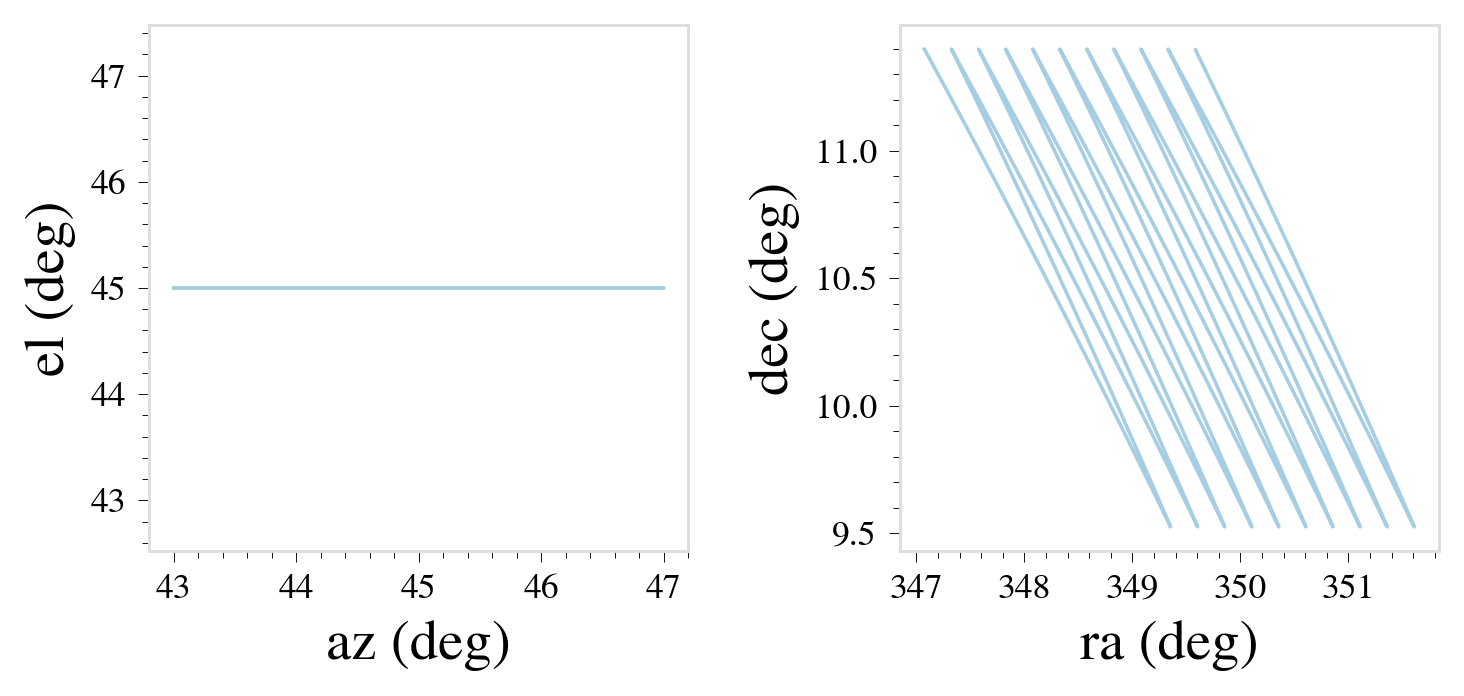

In [356]:
fig, axes = plt.subplots(1,2,figsize=(6,3),dpi=256, tight_layout=True)




r, d = c.transform(model.azim, model.elev, frames='ae>rd')


axes[0].plot(np.degrees(model.azim[0]), np.degrees(model.elev[0]))
axes[0].set_xlabel('az (deg)'), axes[0].set_ylabel('el (deg)')

axes[1].plot(np.degrees(model.ra[0]), np.degrees(model.dec[0]))
axes[1].set_xlabel('ra (deg)'), axes[1].set_ylabel('dec (deg)')



In [357]:
%time model.simulate_atmosphere()

Integrating spectra: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

CPU times: user 26.6 s, sys: 2.65 s, total: 29.2 s
Wall time: 7.98 s


Text(0, 0.5, '(deg)')

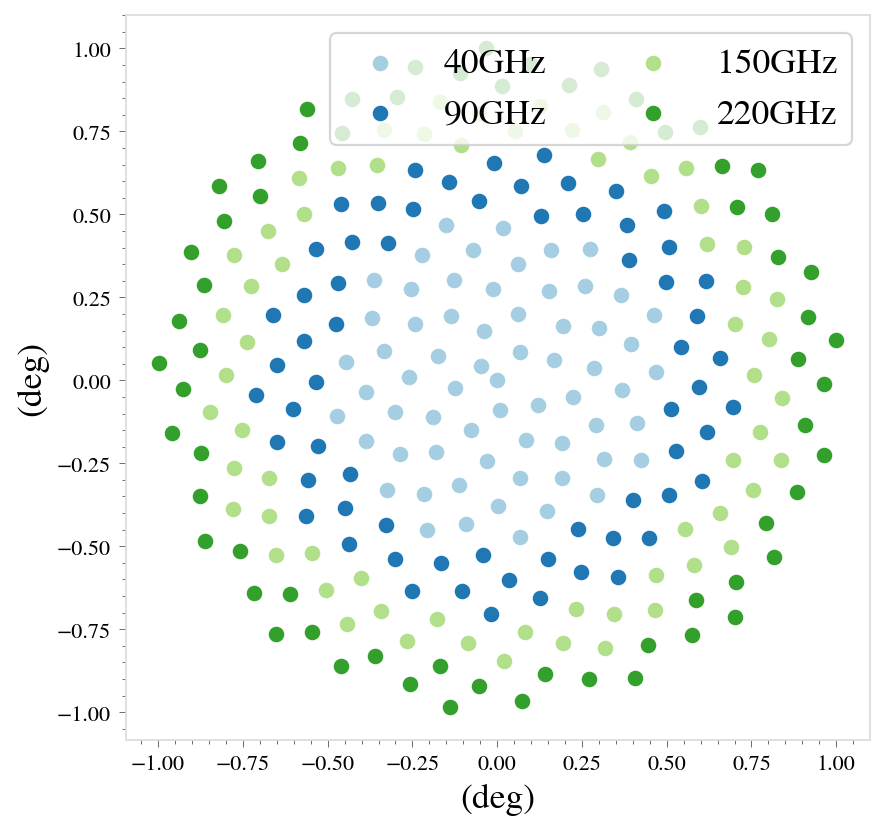

In [358]:

fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=160)

nt = 1200

D  = model.atm_power_data[:,:nt].copy()
D -= D.mean(axis=1)[:,None]

for ib, b in enumerate(model.array.ubands):

    bm = model.array.bands == b

    ax.scatter(np.degrees(model.array.offset_x[bm]), 
               np.degrees(model.array.offset_y[bm]), c=HEX_list[ib], label=f'{int(1e-9*b)}GHz')

ax.legend(ncol=2)
ax.set_xlabel('(deg)')
ax.set_ylabel('(deg)')


Text(0, 0.5, 'T (pW)')

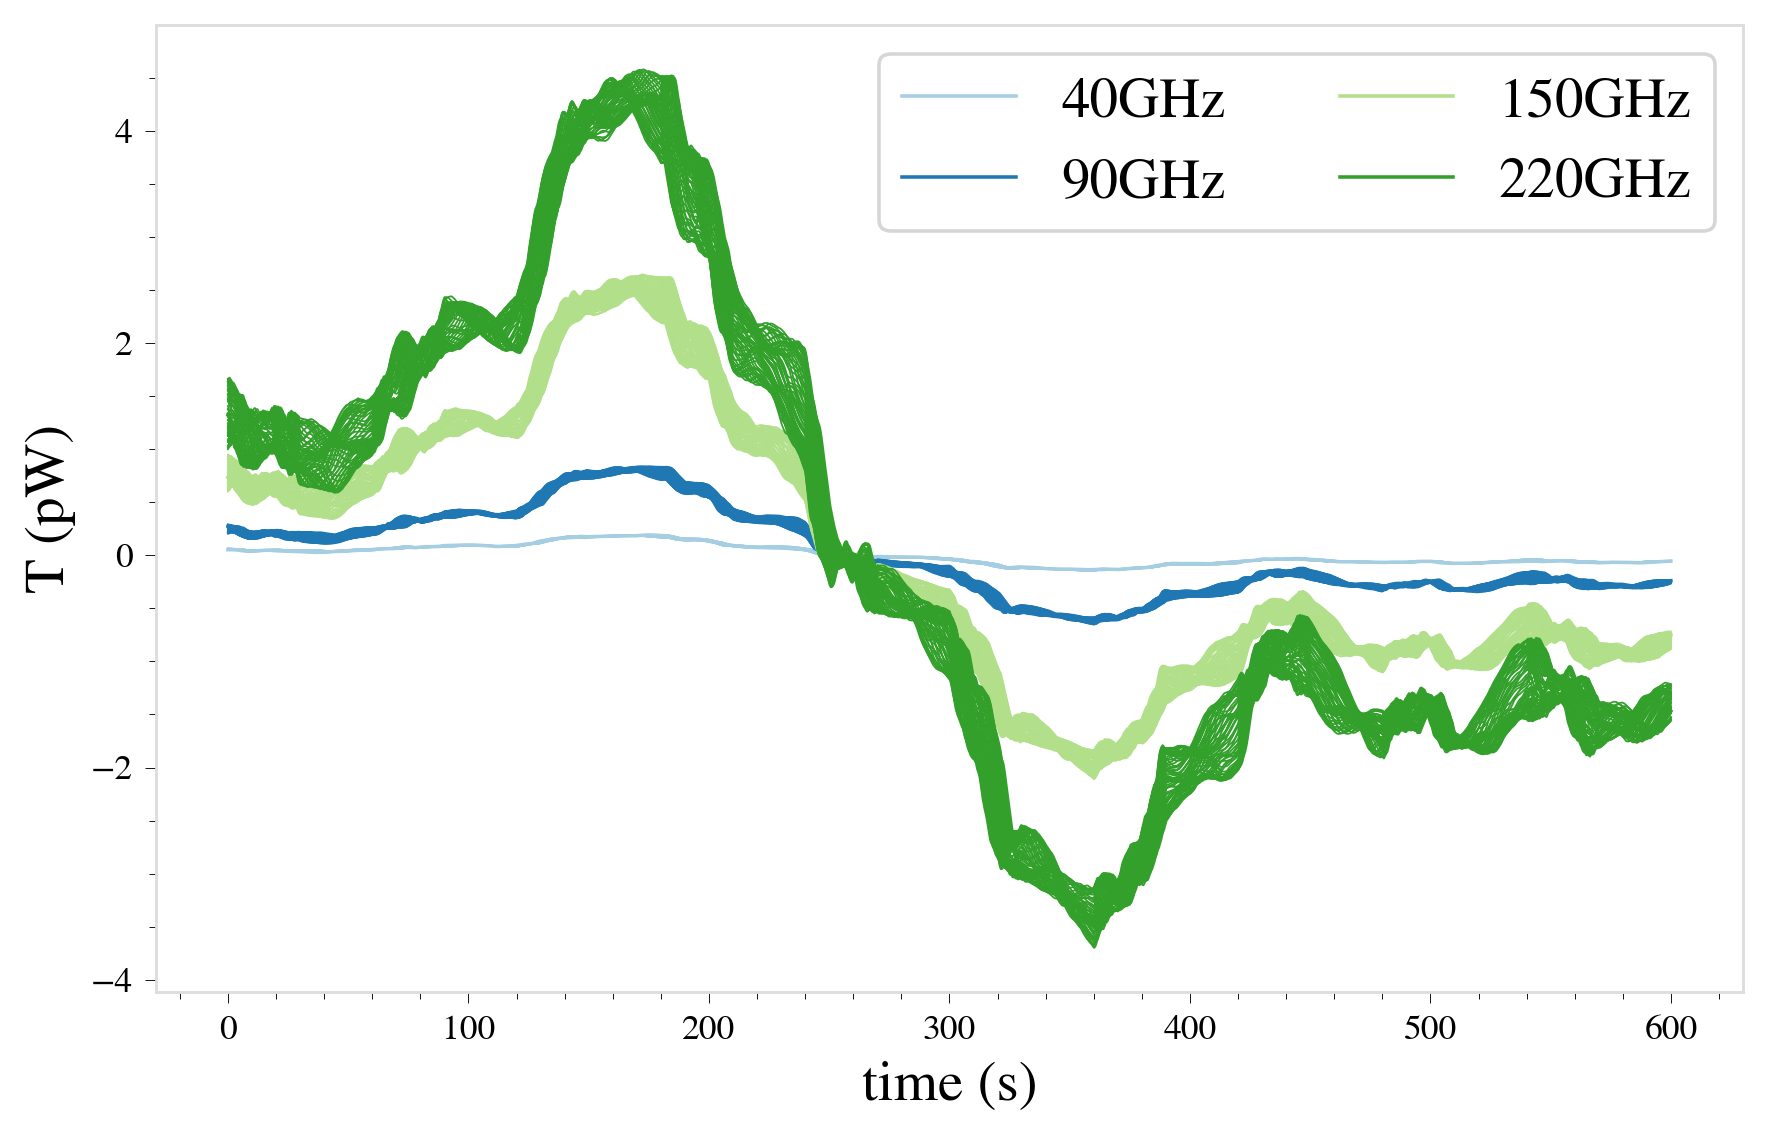

In [359]:

fig, ax = plt.subplots(1,1,figsize=(8,5), dpi=256)

nt = 12000
nt = len(model.plan.time)

D  = model.atm_power_data[:,:nt].copy()
D -= D.mean(axis=1)[:,None]

for ib, b in enumerate(model.array.ubands):

    bm = model.array.bands == b

    for d in D[bm]:

        ax.plot(model.plan.time[:nt], d, c=HEX_list[ib], lw=5e-1)

    ax.plot(model.plan.time[:nt], d, c=HEX_list[ib], label=f'{int(1e-9*b)}GHz')

ax.legend(ncol=2)
ax.set_xlabel('time (s)')
ax.set_ylabel('T (pW)')


In [62]:
model.atm_power_data.shape

(256, 12000)

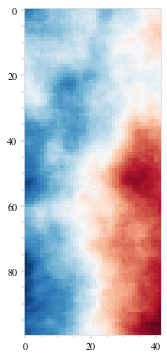

In [63]:
plt.figure(figsize=(6,6))
plt.imshow(model.vals[0][:100])

In [64]:
from astropy.io import fits
hdul = fits.open('maps/tsz.fits')

map_TRJ = -5.37 * 1e7 * hdul[0].data
map_res = np.radians(1/3600)

map_nx, map_ny = map_TRJ.shape
map_ra  = map_res * map_nx * np.linspace(-0.5, 0.5, map_nx) + model.ra.mean()
map_dec = map_res * map_ny * np.linspace(-0.5, 0.5, map_ny) + model.dec.mean()

map_RA, map_DEC = np.meshgrid(map_ra, map_dec, indexing='ij')



In [65]:
far_field_angular_waist = 2 * model.array.get_beam_waist(w_0=0.5*model.array.primary_size, z=1e16, f=1.5e11) / 1e16

0.25 * far_field_angular_waist

0.0001272390718372006

In [66]:
binned_map_res = far_field_angular_waist / 4

ra_mids  = np.arange(model.ra.min() - binned_map_res, model.ra.max() + binned_map_res, binned_map_res)
dec_mids = np.arange(model.dec.min() - binned_map_res, model.dec.max() + binned_map_res, binned_map_res)

ra_bins  = np.array([*ra_mids - 0.5 * binned_map_res, ra_mids[-1] + 0.5 * binned_map_res])
dec_bins = np.array([*dec_mids - 0.5 * binned_map_res, dec_mids[-1] + 0.5 * binned_map_res])

binned_map_TRJ = sp.stats.binned_statistic_2d(map_RA.ravel(), map_DEC.ravel(), map_TRJ.ravel(), bins=(ra_bins, dec_bins), statistic='mean')[0] 
binned_map_TRJ[np.isnan(binned_map_TRJ)] = 0

BRA, BDEC = np.meshgrid(ra_mids, dec_mids, indexing='ij')


binned_map_filter = model.array.make_filter(waist=far_field_angular_waist, res=binned_map_res, func=model.array.beam_func)
FB_map_TRJ = model.array.separably_filter(binned_map_TRJ, binned_map_filter)

BF_map_RGI = sp.interpolate.RegularGridInterpolator((ra_mids, dec_mids), FB_map_TRJ)

map_data = BF_map_RGI((model.ra, model.dec))

Text(0, 0.5, 'T (CMB_uK)')

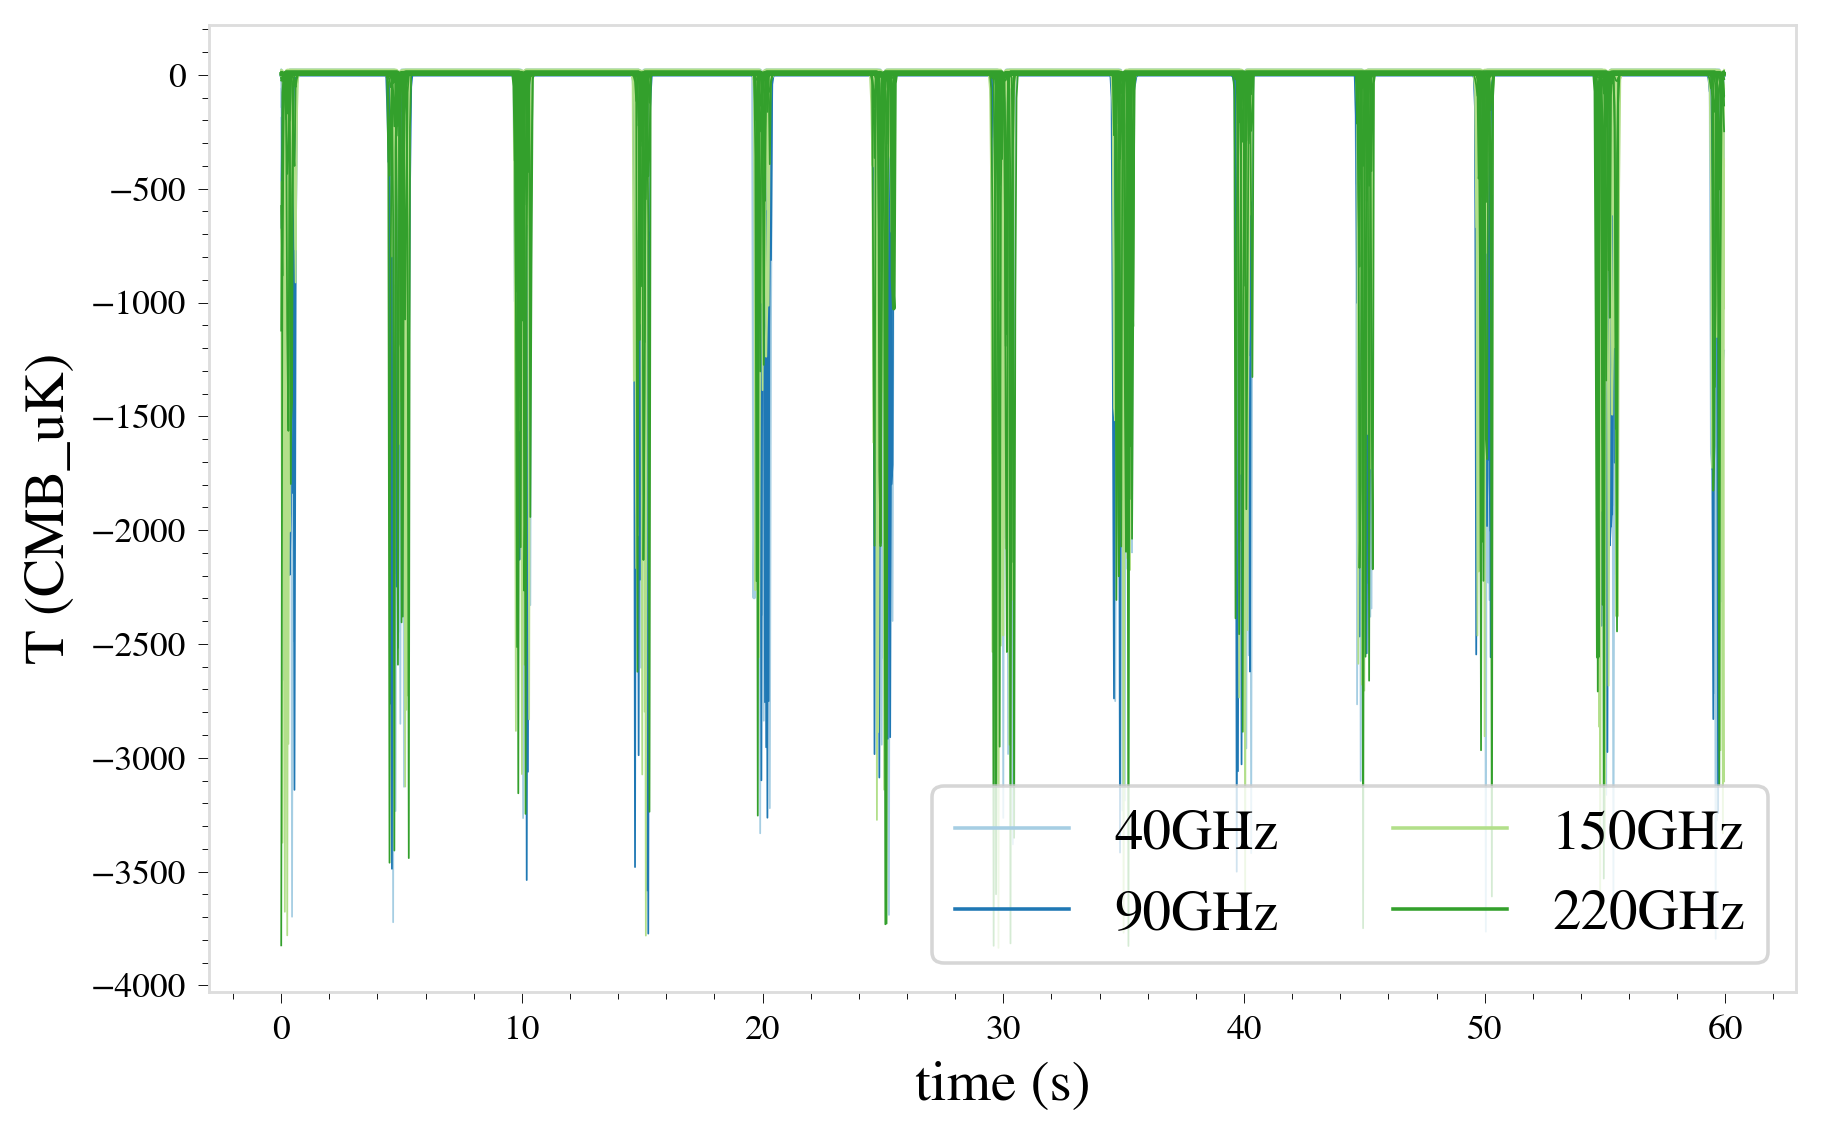

In [52]:

fig, ax = plt.subplots(1,1,figsize=(8,5), dpi=256)

nt = 12000
nt = len(model.plan.time)

D  = map_data[:,:nt].copy()
D -= D.mean(axis=1)[:,None]

for ib, b in enumerate(model.array.ubands):

    bm = model.array.bands == b

    for d in D[bm]:

        ax.plot(model.plan.time[:nt], d, c=HEX_list[ib], lw=5e-1)

    ax.plot(model.plan.time[:nt], d, c=HEX_list[ib], label=f'{int(1e-9*b)}GHz')

ax.legend(ncol=2)
ax.set_xlabel('time (s)')
ax.set_ylabel('T (CMB_uK)')


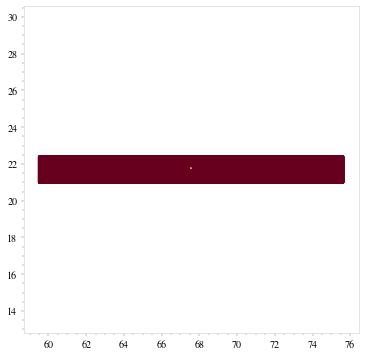

In [37]:

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(np.degrees(BRA), np.degrees(BDEC), c=FB_map_TRJ, s=1)
#ax.plot(np.degrees(model.ra).T, np.degrees(model.dec).T)

xs = ax.get_xlim()
ys = ax.get_ylim()

x0, y0 = np.mean(xs), np.mean(ys)
r = 0.5 * np.maximum(np.ptp(xs), np.ptp(ys))

ax.set_xlim(x0-r,x0+r)
ax.set_ylim(y0-r,y0+r)

plt.show()

In [198]:
np.ptp(map_X)

0.0048481368110953596

In [199]:
map_RA, map_DEC = tools.from_xy(map_X, map_Y, model.ra.mean(), model.dec.mean())

In [145]:
import ephem

observer = ephem.Observer()
observer.lon = np.radians(0)
observer.lat = np.radians(90)
observer.elevation = 0
observer.date = 
observer.radec_of(0, np.pi/2)

SyntaxError: invalid syntax (1678870252.py, line 7)

In [146]:
ae_to_rd(az, el, lst, lat)

NameError: name 'ae_to_rd' is not defined

In [147]:
azim_sample, elev_sample = np.linspace(model.azim.min(), model.azim.max(), 64), np.linspace(model.elev.min(), model.elev.max(), 64)

RA, DEC = np.vectorize(observer.radec_of)(*np.meshgrid(azim_sample, elev_sample))


86164.091

In [154]:
#plt.plot((model.azim - model.azim.max())[0] % (2*np.pi))

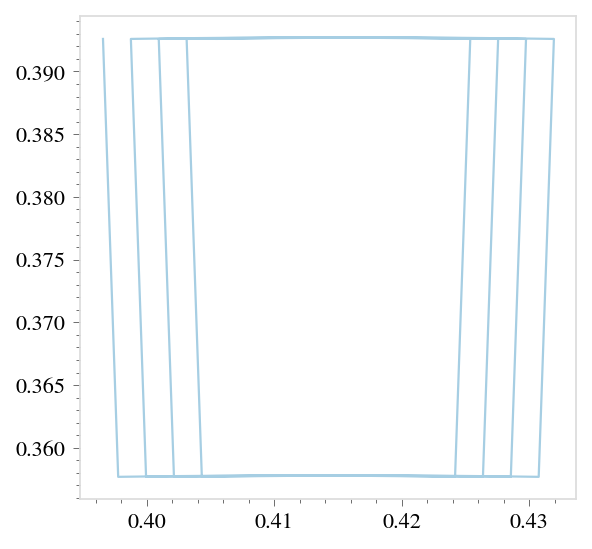

In [189]:
# LST=100.46+0.985647*d+long+15⋅UT



model.plan.J2000 = (model.plan.time - J0) % 86400



plt.plot(ra[0], dec[0])

In [171]:
np.degrees(dec)

-23.499999999999993

In [164]:
plt.plot(ra[0])

IndexError: invalid index to scalar variable.

In [127]:
from scipy.interpolate import RegularGridInterpolator as rgi


%time ra_rgi = rgi((azim_sample, elev_sample), RA)((model.azim, model.elev))

CPU times: user 92 ms, sys: 18.6 ms, total: 111 ms
Wall time: 108 ms


In [117]:
model.azim.shape

(256, 2400)

In [116]:
%time x(model.azim, model.elev)

CPU times: user 1.59 s, sys: 32.7 ms, total: 1.62 s
Wall time: 1.63 s


(array([[1.85723523, 1.85725357, 1.85727195, ..., 1.85375227, 1.85491327,
         1.85607425],
        [1.85833705, 1.85835647, 1.85837593, ..., 1.85485413, 1.85601511,
         1.85717608],
        [1.85832089, 1.85834028, 1.85835971, ..., 1.85483796, 1.85599895,
         1.85715992],
        ...,
        [1.84742379, 1.84743257, 1.84744135, ..., 1.84394064, 1.8451017 ,
         1.84626275],
        [1.84852577, 1.84853563, 1.8485455 , ..., 1.84504266, 1.8462037 ,
         1.84736474],
        [1.84962864, 1.84963958, 1.84965053, ..., 1.84614556, 1.8473066 ,
         1.84846762]]),
 array([[0.69522772, 0.69639197, 0.69755622, ..., 0.69526006, 0.69524928,
         0.6952385 ],
        [0.69570238, 0.69686662, 0.69803085, ..., 0.69573471, 0.69572393,
         0.69571315],
        [0.69473218, 0.69589642, 0.69706065, ..., 0.69476451, 0.69475373,
         0.69474295],
        ...,
        [0.6996614 , 0.70082567, 0.70198994, ..., 0.69969383, 0.69968301,
         0.6996722 ],
        [0.7

In [104]:
datetime.fromtimestamp(model.plan.time[0])

datetime.datetime(1969, 12, 31, 19, 0)

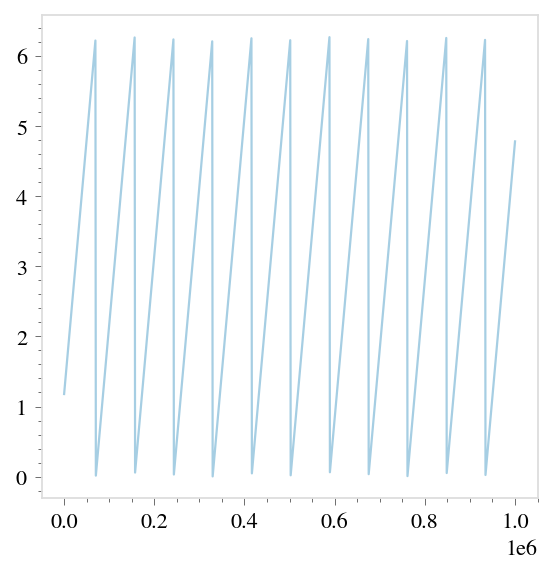

In [85]:
model.plan.lst = 2 * np.pi * model.plan.time / 86400



def get_lst(utc, lon):

    return (2 * np.pi * (utc / 86400) - lon) % (2 * np.pi)

t = np.linspace(0,1e6,1024)

plt.plot(t, get_lst(t, np.radians(-67.5)))

In [94]:
model.plan.lst = get_lst(model.plan.time, np.radians(model.site.longitude))

ra, dec = maria.tools.ae_to_rd(model.azim, 0, model.plan.lst, np.radians(model.site.latitude))
ra.mean(), dec.mean()

(1.1826309273963016, 1.1548206541303536)

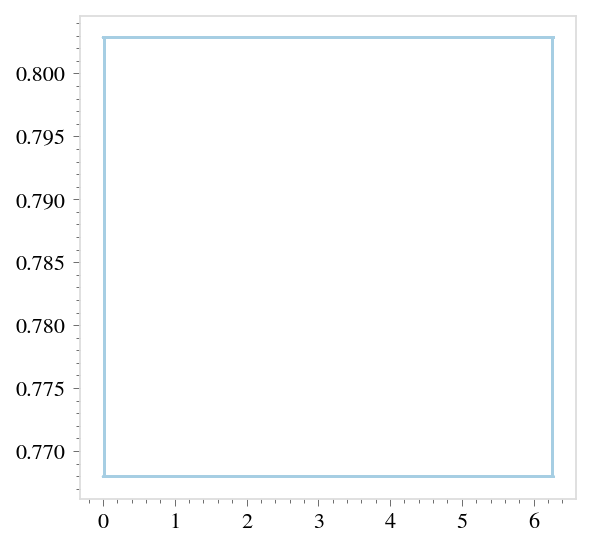

In [150]:
plt.plot(model.azim[0], model.elev[0])

In [86]:
model.site.longitude

-67.5

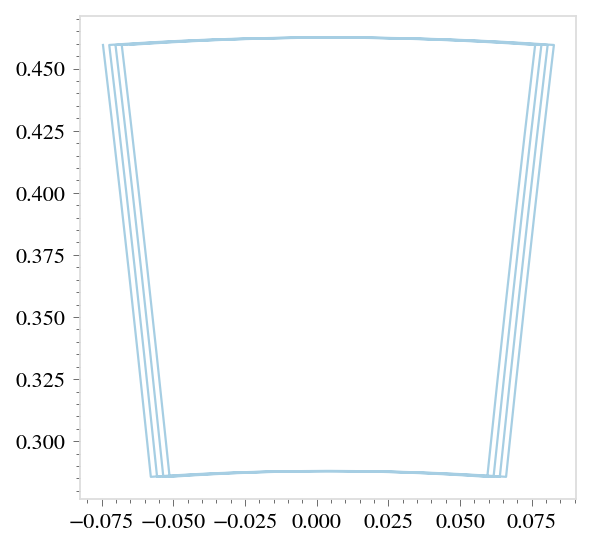

In [81]:
plt.plot(ra[0], dec[0])

In [80]:

fluc_norm = np.square(site.weather['pwv_rms']) * np.square(model.layer_scaling) / np.square(model.layer_scaling).sum(axis=0)

In [66]:
plan.o

AttributeError: 'plan' object has no attribute 'o'

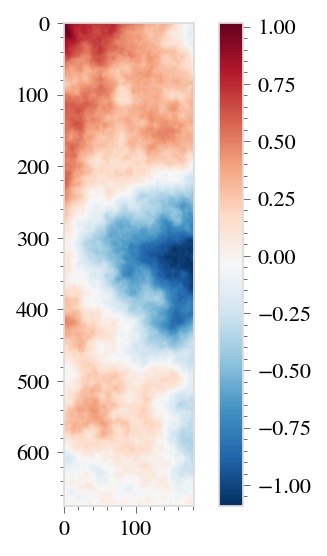

In [83]:
plt.imshow(model.vals[0])
plt.colorbar()

In [84]:
self.rel_flucs.astype(float).std(axis=(1,2))

array([0.41890984, 0.44905829, 0.49508883, 0.70774142, 0.79545871])

In [85]:
self.A[0].sum(axis=1)

array([0.99979544, 0.99986815, 0.99989265, 0.9999107 , 0.99992424,
       0.9999309 , 0.9999352 , 0.99994004, 0.9999447 , 0.99994636,
       0.99994767, 0.9999503 , 0.9999532 , 0.999954  , 0.99995476,
       0.99995697, 0.99996024, 0.99996203, 0.9999633 , 0.99996364,
       0.99996334, 0.9999623 , 0.9999617 , 0.9999627 , 0.9999639 ,
       0.9999636 , 0.9999634 , 0.9999644 , 0.99996567, 0.9999652 ,
       0.999965  , 0.99996614, 0.99996734, 0.99996746, 0.99996734,
       0.99996805, 0.9999689 , 0.99996924, 0.9999685 , 0.99996847,
       0.9999692 , 0.99996984, 0.99996966, 0.99996924, 0.99996996,
       0.9999707 , 0.9999705 , 0.9999705 , 0.9999711 , 0.99997175,
       0.99997175, 0.9999715 , 0.9999722 , 0.999973  , 0.9999734 ,
       0.9999733 , 0.99997365, 0.999974  , 0.9999734 , 0.99997336,
       0.9999737 , 0.99997413, 0.9999737 , 0.99997354, 0.9999741 ,
       0.9999743 , 0.999974  , 0.9999738 , 0.9999742 , 0.9999748 ,
       0.9999746 , 0.9999746 , 0.9999745 , 0.99997485, 0.99997

In [86]:
self.epwv_data  = self.rel_flucs * np.sqrt(np.square(self.site.weather['pwv_rms']) * np.square(self.layer_scaling))[:,None,:]
self.epwv_data /= (self.n_layers * np.sin(maria.tools.from_xy(*self.array.offsets.T[:,:,None], 0, model.plan.c_elev)[1]))

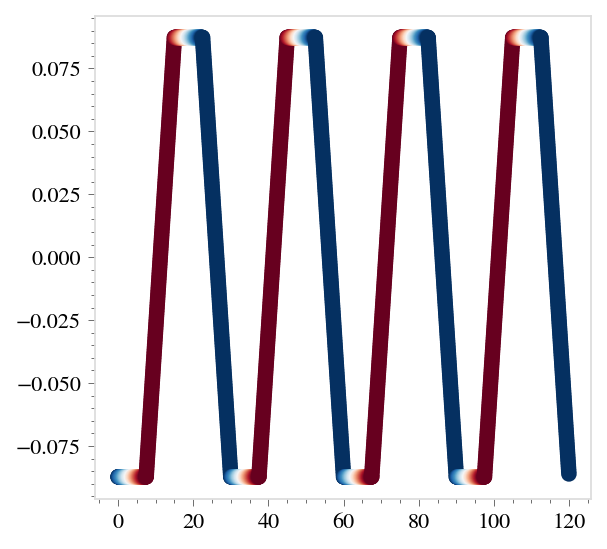

In [92]:
plt.scatter(model.plan.time, model.plan.c_azim, c=model.plan.c_elev)

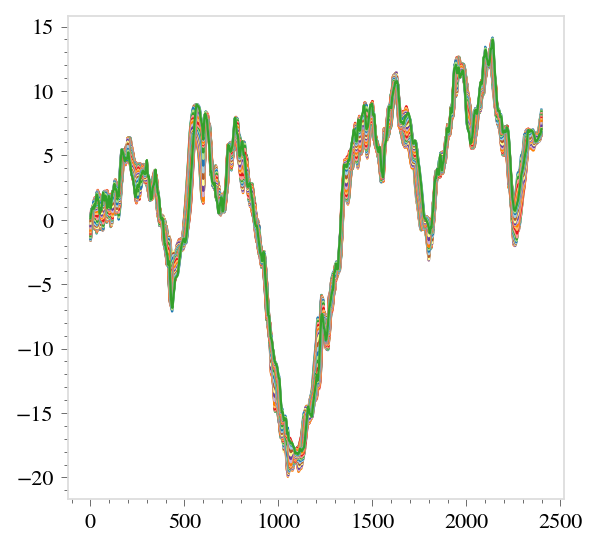

In [87]:
plt.plot(self.epwv_data.sum(axis=0).T)
plt.show()

In [ ]:
np.square(site.weather['pwv_rms']) * 

In [30]:
model.layer_scaling

array([[5.77844623, 5.77954593, 5.78064554, ..., 5.77844623, 5.77844623,
        5.77844623],
       [5.45449619, 5.45402935, 5.45356214, ..., 5.45449619, 5.45449619,
        5.45449619],
       [2.78092262, 2.77992134, 2.77891977, ..., 2.78092262, 2.78092262,
        2.78092262],
       [1.01998018, 1.01897487, 1.01796937, ..., 1.01998018, 1.01998018,
        1.01998018]])

Generating layers: 100%|██████████| 12555/12555 [00:04<00:00, 2606.39it/s]


In [286]:
model.rel_flucs.shape

(2, 256, 12000)

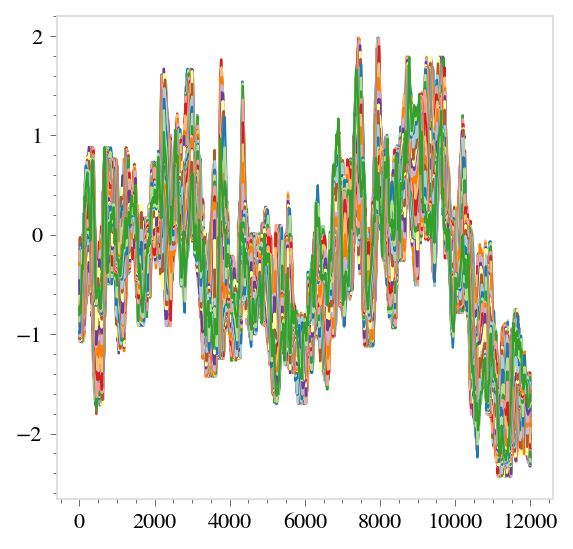

In [287]:
plt.plot(model.rel_flucs[1].T)
plt.show()


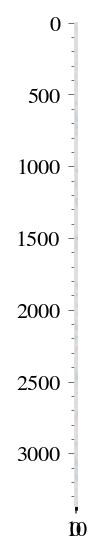

In [149]:
plt.imshow(model.vals[0].astype(float))

In [251]:
i_d = 0
i_f = 0

multichromatic_beams = False

for i_d, d in enumerate(model.depths):
    
    if multichromatic_beams:
    
        filtered_vals   = np.zeros((len(model.array.nu), *model.vals[i_d].shape), dtype=model.data_type)
        angular_res = model.lay_ang_res[i_d]

        print(filt_vals.shape)

        for i_f, f in enumerate(model.array.nu):

            angular_waist = model.angular_waists[i_d, i_f]

            F = model.array.make_filter(angular_waist, angular_res, model.array.beam_func)
            u, s, v = model.array.separate_filter(F)

            filtered_vals[i_f] = model.array.separably_filter(model.vals[i_d], u, s, v).astype(model.data_type)
            
    else:
        
        angular_res   = model.lay_ang_res[i_d]
        angular_waist = model.angular_waists[i_d, i_f].mean()

        F = model.array.make_filter(angular_waist, angular_res, model.array.beam_func)
        u, s, v = model.array.separate_filter(F)

        filtered_vals = model.array.separably_filter(model.vals[i_d], u, s, v).astype(model.data_type)

In [242]:
self = model

FRGI = sp.interpolate.RegularGridInterpolator((self.para[i_d], self.orth[i_d]), self.lay_scaling[i_d] * filtered_vals)
            

ValueError: operands could not be broadcast together with shapes (1200,) (675,358) 

In [253]:
self = model

EPWV = sp.interpolate.RegularGridInterpolator((self.para[i_d], self.orth[i_d]), filtered_vals)((self.p[i_d], self.o[i_d]))
            

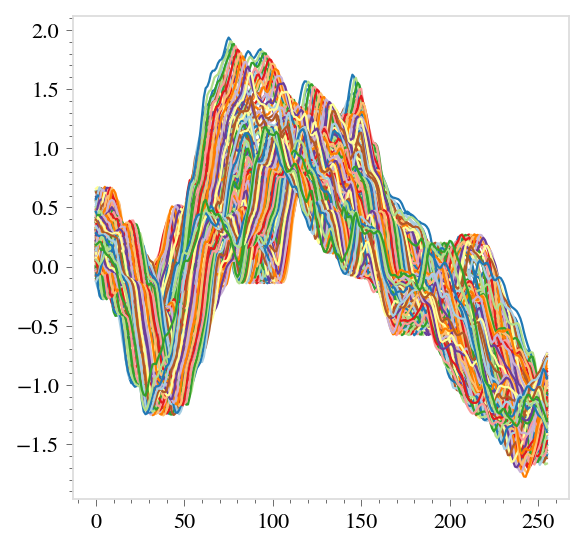

In [258]:
plt.plot(EPWV[:,:256].T)
plt.show()

In [ ]:
self.para[i_d]

In [244]:
i_d = 1

print(self.p[i_d].min(), self.p[i_d].max())
print(self.para[i_d].min(), self.para[i_d].max())

-0.07685334374339767 0.3401912122814538
-0.07948351959597512 0.342209065559014


In [245]:
model.padding

array([0.00400226, 0.00200452])

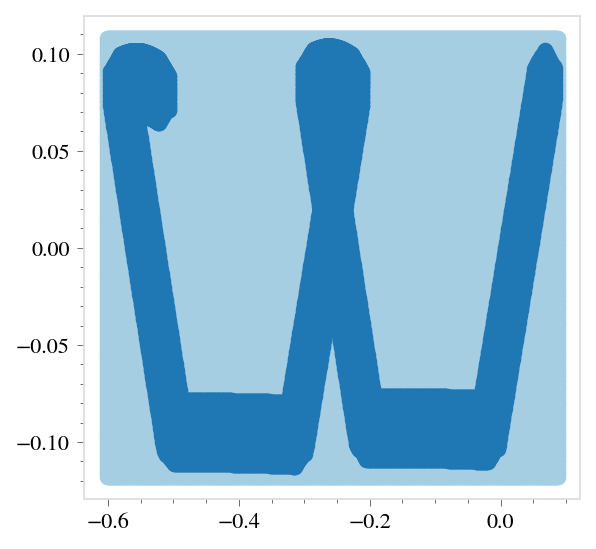

In [246]:
i_d = 0

plt.scatter(*np.meshgrid(self.para[i_d], self.orth[i_d]))
plt.scatter(self.p[i_d], self.o[i_d])
plt.show()

In [151]:
from scipy.interpolate import RegularGridInterpolator as rgi

EPWV = sp.interpolate.RegularGridInterpolator((self.para[i_d], self.orth[i_d]), filtered_vals)((self.p[i_d], self.o[i_d]))

rgi

In [161]:
self.lay_scaling[i_d].shape

(1200,)

In [145]:
np.degrees(angular_waist), 

0.14356311250114662

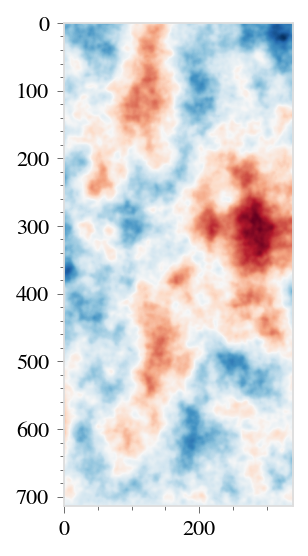

In [144]:
plt.imshow(filt_vals.astype(float))

In [134]:
model.waists[i_d]

array([5.011298  , 5.01110173, 5.01091053, 5.01072423, 5.01054266,
       5.01036566, 5.01019308, 5.01002477, 5.00986059, 5.00970041,
       5.00954411, 5.00939155, 5.00924261, 5.0090972 , 5.00895518,
       5.00881647, 5.00868095, 5.00854853, 5.00841912, 5.00829262,
       5.00816895, 5.00804803, 5.00792977, 5.0078141 , 5.00770094,
       5.00759022, 5.00748187, 5.00737583, 5.00727202, 5.00717038,
       5.00707087, 5.00697341, 5.00687795, 5.00678444, 5.00669282,
       5.00660304, 5.00651506, 5.00642882, 5.00634429, 5.00626141,
       5.00618014, 5.00610045, 5.00602228, 5.00594561, 5.0058704 ,
       5.0057966 , 5.00572418, 5.00565312, 5.00558337, 5.0055149 ,
       5.00544768, 5.00538168, 5.00531688, 5.00525324])

In [130]:
angular_waist

0.0025026266181304743

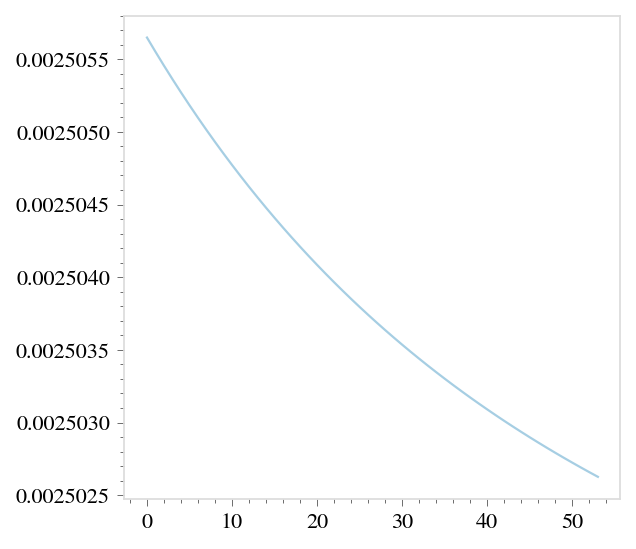

In [131]:
plt.plot(model.angular_waists[i_d])

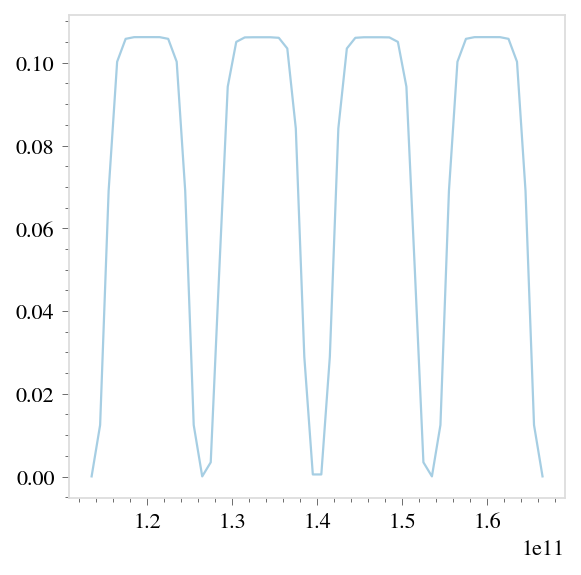

In [132]:
plt.plot(model.array.nu, model.array.passbands.max(axis=0))

In [126]:
filt_vals[0] - filt_vals[-1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

In [44]:
model.array.separably_filter(model.vals[i_l].astype(float), u, s, v).shape

(2393, 192)

In [45]:
model.vals[i_l].shape

(2393, 192)

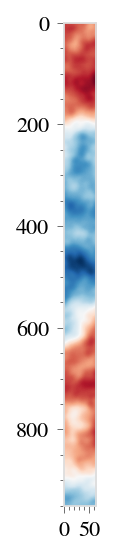

In [20]:
plt.imshow(model.array.separably_filter(model.vals[i_l],u, s, v))

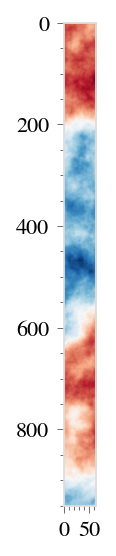

In [19]:
plt.imshow(model.vals[0])

In [138]:
model.depths

array([1000., 2000.])

In [206]:
i_l = 0
i_f = 0

model.angular_waists[i_l]

array([0.00500179, 0.00500174, 0.0050017 , 0.00500165, 0.00500161,
       0.00500157, 0.00500153, 0.00500149, 0.00500145, 0.00500141,
       0.00500138, 0.00500135, 0.00500131])

In [211]:
model.n_layers

2

In [221]:
for i_l, l in enumerate(model.depths):
    for i_f, f in enumerate(model.array.nu):

        waist = model.angular_waists[i_l, i_f]

        filter_width_per_waist = 1.5

        filter_width = filter_width_per_waist * waist

        n_filter = 2 * int(np.ceil(0.5 * filter_width / model.lay_ang_res[i_l])) + 1

        filter_side = 0.5 * np.linspace(-filter_width, filter_width, n_filter)

        FILTER_X, FILTER_Y = np.meshgrid(filter_side, filter_side, indexing='ij')
        FILTER_R = np.sqrt(np.square(FILTER_X) + np.square(FILTER_Y))

        FILTER  = model.array.beam_func(FILTER_R, 0.5 * waist)
        FILTER /= FILTER.sum()

        thresh = 0.9

        filtered = 0
        for m in range(np.where(np.cumsum(s) / np.sum(s) > thresh)[0][0] + 1):

            filtered += s[m] * sp.ndimage.filters.convolve1d(sp.ndimage.filters.convolve1d(raw, v[m], axis=0), v[m], axis=1)
            
        

In [209]:
%time u, s, v = la.svd(FILTER)
s

CPU times: user 202 µs, sys: 45 µs, total: 247 µs
Wall time: 215 µs


array([1.09655974e-01, 1.77924733e-02, 4.85465176e-03, 1.53254037e-03,
       4.62320488e-04, 1.57149708e-05, 1.35854094e-05, 3.24941131e-17,
       8.58144901e-18, 4.62905979e-18, 1.20580224e-18, 4.93380458e-19,
       1.18279558e-19, 3.73126334e-22, 7.63514782e-27])

In [186]:
raw = model.vals[i_l].copy()

In [187]:
#plt.plot(v[0])

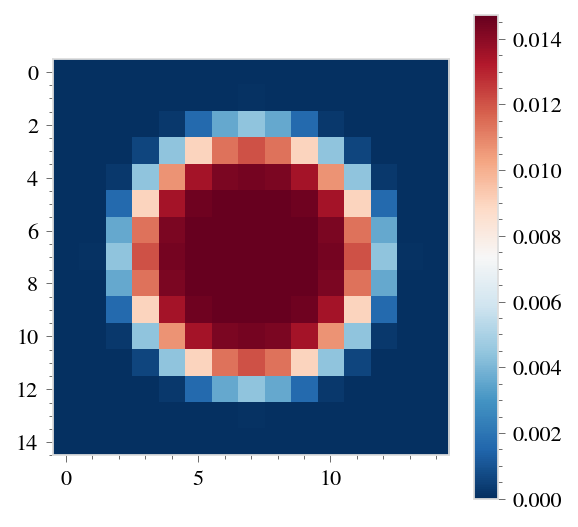

In [210]:
plt.imshow(FILTER)
plt.colorbar()

In [97]:
model.array.beam_func()

TypeError: <lambda>() missing 2 required positional arguments: 'r' and 'r_fwhm'

In [62]:
i_l = 0

model.radii = 0.5 * model.waists
model.lay_ang_res[i_l]

0.0046780351198783985

In [ ]:
filter_width_per_waist = 1.5

n

filter_width_per_waist * np.arange(-0.5, 0.5, )

In [60]:
model.radii[0]

array([25.0000009 , 25.00000087, 25.00000085, 25.00000083, 25.0000008 ,
       25.00000078, 25.00000076, 25.00000074, 25.00000072, 25.00000071,
       25.00000069, 25.00000067, 25.00000066])

In [57]:
#model.waists

In [53]:
model.X[0]

array([[-0.18569226, -0.18517663, -0.18466101, ..., -0.15423923,
        -0.15372361, -0.15320799],
       [-0.18104273, -0.1805271 , -0.18001148, ..., -0.1495897 ,
        -0.14907408, -0.14855845],
       [-0.17639319, -0.17587757, -0.17536195, ..., -0.14494017,
        -0.14442455, -0.14390892],
       ...,
       [ 2.64587255,  2.64638818,  2.6469038 , ...,  2.67732558,
         2.6778412 ,  2.67835683],
       [ 2.65052209,  2.65103771,  2.65155333, ...,  2.68197511,
         2.68249073,  2.68300636],
       [ 2.65517162,  2.65568724,  2.65620286, ...,  2.68662464,
         2.68714027,  2.68765589]])

In [44]:
from astropy.io import fits
hdul = fits.open('maps/tsz.fits')
#plt.imshow(-5.37 * hdul[0].data)
#plt.colorbar()

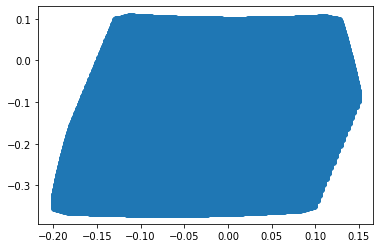

In [706]:
plt.scatter(model.rel_c_x[-1][None,:] + model.array.offset_x[:,None],
            model.rel_c_y[-1][None,:] + model.array.offset_y[:,None])

In [ ]:
w = model.angular_waists[i_l].mean()
model.array.get_beam_filter()

In [707]:
i_l = 0
res = model.lay_ang_res[i_l]

raw = model.vals[i_l]

filt = np.zeros(())

In [708]:
[60 * np.degrees(x) for x in model.lay_ang_res]

[21.315583193208916,
 19.304075981479347,
 14.323948266166985,
 10.742963175897726,
 8.594372573455171,
 7.161979214925698,
 6.138841424346279,
 5.371488363735353,
 4.7746584564364625,
 4.297194756455689]

In [709]:
[60 * np.degrees(x.mean()) for x in model.angular_waists]

[171.88734668976375,
 85.94368557065577,
 57.29580396462751,
 42.97186723686593,
 34.37750846040738,
 28.647938659596413,
 24.55539113058002,
 21.485982521430984,
 19.09866652552252,
 17.18881535887803]

In [711]:
34.38152563429087 / 4.2974640910153665

8.000421854872906

In [712]:
n_bf = int(np.ceil(.5 * w / res))
n_bf

5

In [713]:
model.array.get_beam_filter()

TypeError: <lambda>() missing 3 required positional arguments: 'dx', 'dy', and 'w'

In [714]:
beam_side = np.arange(-2 * n_bf, 2 * n_bf)
DX, DY = np.meshgrid(beam_side, beam_side)

BF = model.array.get_beam_filter(DX, DY, w / res)
BF /= BF.sum()

In [715]:
%time f = sp.signal.convolve2d(raw, BF, boundary='symm', mode='same')

CPU times: user 16.8 ms, sys: 127 µs, total: 16.9 ms
Wall time: 16.9 ms


In [734]:
from numpy import linalg as la

t0 = ttime.time()

u, s, v = la.svd(BF)

t0 = ttime.time()

eff_filter = np.zeros(BF.shape)

filtered = np.zeros(raw.shape)
total_s  = 0
mode     = 0
for i, (_u, _s, _v) in enumerate(zip(u.T, s, v)):
    
    filtered_mode = sp.ndimage.filters.convolve1d(raw,           _u, axis=0)
    filtered_mode = sp.ndimage.filters.convolve1d(filtered_mode, _v, axis=1)
    
    eff_filter += _s * np.outer(_u, _v)
    
    filtered += _s * filtered_mode
    total_s += _s
    mode += 1
    print(_s)
    
    if i == 2: break
    
t1 = ttime.time()

t1 - t0

0.06645079166593985
0.010809575593085057
0.003037819547017024


0.004240274429321289

In [725]:
model.array.passbands

array([[7.86438349e-13, 3.04427398e-05, 1.24511210e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.86438349e-13, 3.04427398e-05, 1.24511210e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.86438349e-13, 3.04427398e-05, 1.24511210e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.90570005e-02, 1.24511210e-02, 3.04427398e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.90570005e-02, 1.24511210e-02, 3.04427398e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.90570005e-02, 1.24511210e-02, 3.04427398e-05]])

In [717]:
BF.max()

0.005401303241085676

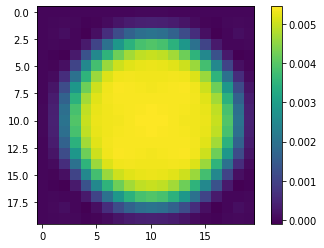

In [735]:
plt.imshow(eff_filter)
plt.colorbar()

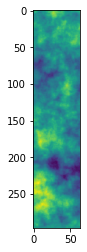

In [737]:
plt.imshow(raw)

In [720]:
%time f = sp.signal.convolve2d(raw, BF, boundary='symm', mode='same')

CPU times: user 17.7 ms, sys: 97 µs, total: 17.8 ms
Wall time: 17.8 ms


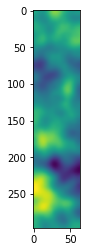

In [738]:
plt.imshow(f)

In [722]:
u,s,v = la.svd()

TypeError: _svd_dispatcher() missing 1 required positional argument: 'a'

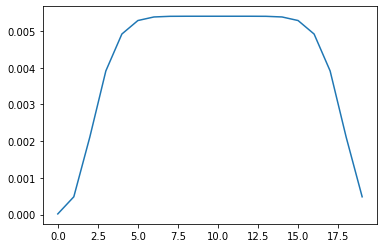

In [723]:
plt.plot(BF[2*n_bf])



In [432]:
np.degrees(w) * 60

34.38907163748927

In [415]:
np.degrees(res)

0.015016006529325051

In [400]:
model.angular_waists[i_l].mean()

0.0010326658049368603

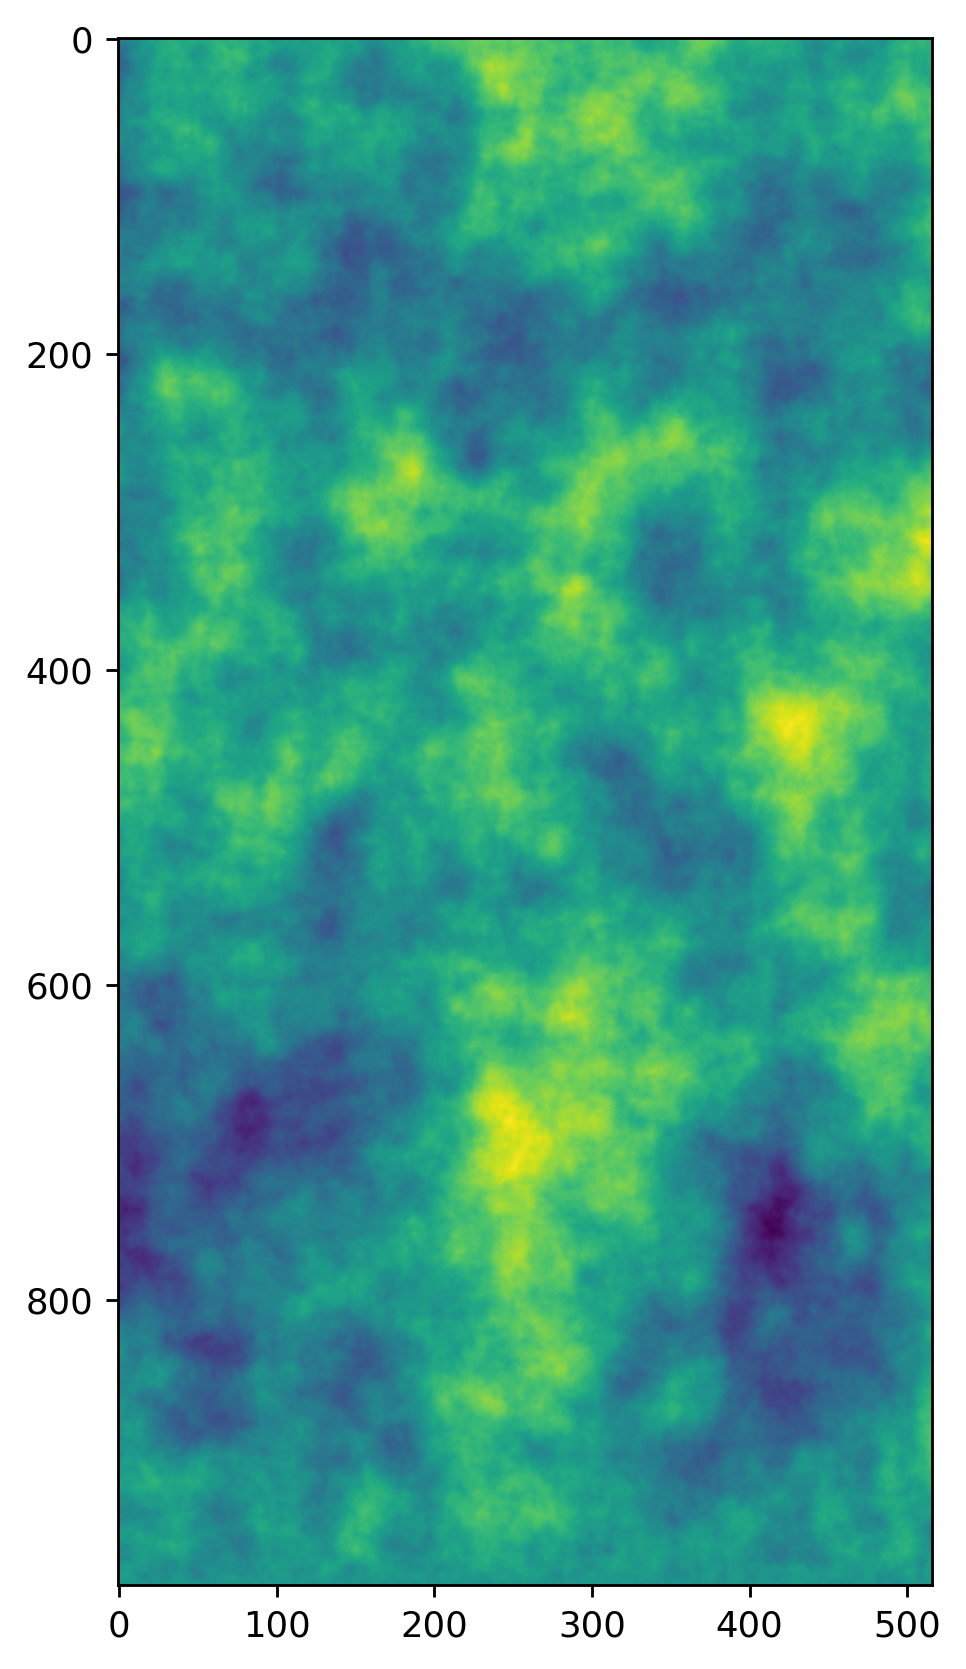

In [390]:
plt.figure(dpi=256, figsize=(8,8))
plt.imshow(model.vals[-1])

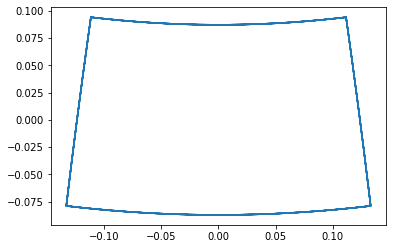

In [356]:
#plt.plot(model.w_v_x[0])
plt.plot(model.plan.c_x, model.plan.c_y)
plt.plot(model.plan.c_x + np.cumsum(), model.plan.c_y)

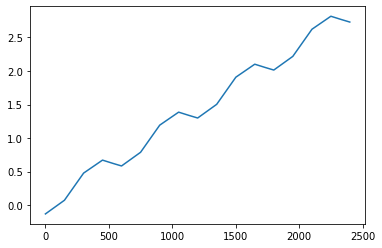

In [374]:
plt.plot(model.rel_c_x[0])

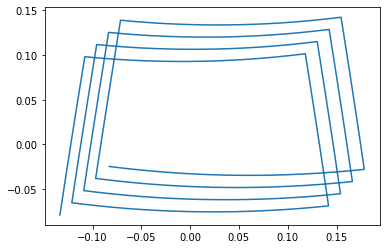

In [363]:
plt.plot(model.plan.c_x + np.cumsum(model.w_v_x * plan.dt, axis=1)[-1], 
         model.plan.c_y + np.cumsum(model.w_v_y * plan.dt, axis=1)[-1])

In [331]:
model.theta_y.shape

(256, 2400)

In [326]:
plan.c_x.shape

(2400,)

In [336]:
model.w_v_x.shape

(5, 2400)

In [313]:
model.sim()

NameError: name 'ttime' is not defined

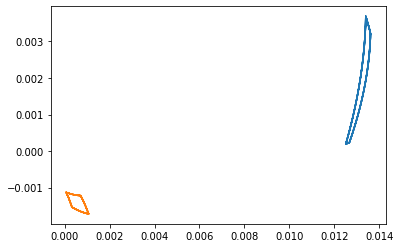

In [311]:
plt.plot(model.wind_x_v[0], model.wind_y_v[0])
plt.plot(model.wind_x_v[-1], model.wind_y_v[-1])

In [304]:
plt.imshow(model.vals[0])

AttributeError: 'lam' object has no attribute 'vals'

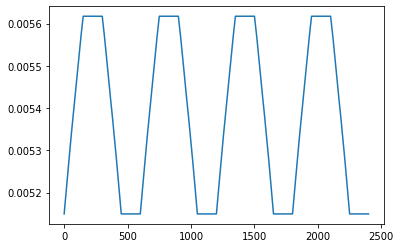

In [299]:
plt.plot(model.lay_scaling[0])

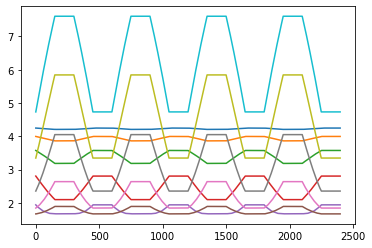

In [212]:
plt.plot(model.w_n.T)
plt.show()

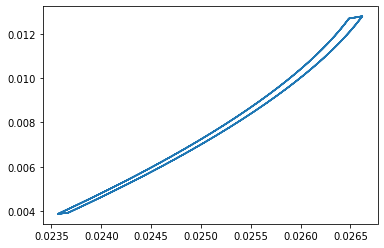

In [213]:
plt.plot(model.wind_x_v[0], model.wind_y_v[0])
plt.show()

In [214]:
model.wind_x[0]

AttributeError: 'lam' object has no attribute 'wind_x'

In [111]:
import weathergen

In [112]:
model.weather['pwv']

7.265072980923543

CPU times: user 645 µs, sys: 481 µs, total: 1.13 ms
Wall time: 616 µs


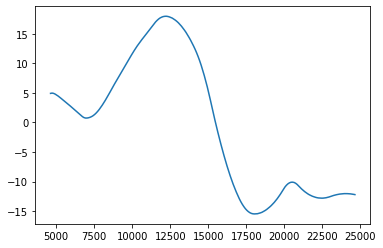

In [83]:
%time weather = weathergen.generate(region='chajnantor', time=0, method='random')
plt.plot(weather['height'], weather['wind_east'])

In [76]:
weather.keys()

dict_keys(['lpwv', 'lnwd', 'temperature', 'wind_east', 'wind_north', 'pwv', 'water_density', 'height'])

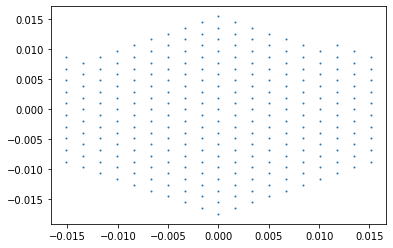

In [63]:
plt.scatter(array.offset_x, array.offset_y, s=1)

In [6]:
layer_beam_edges.shape

NameError: name 'layer_beam_edges' is not defined

In [9]:
waist_sample_prop + beam_tol

NameError: name 'waist_sample_prop' is not defined

In [10]:
layer_array_hulls = [sp.spatial.qhull.ConvexHull(np.c_[x.ravel(),y.ravel()]) for x, y in zip(np.real(layer_beam_edges_z), np.imag(layer_beam_edges_z))]

NameError: name 'layer_beam_edges_z' is not defined

In [11]:
layer_array_hull_x, layer_array_hull_y = [h.points[h.vertices][:,0] for h in layer_hulls], [h.points[h.vertices][:,1] for h in layer_hulls]


NameError: name 'layer_hulls' is not defined

In [12]:
#layer_hull_x

In [457]:
i_layer = 0

array_hull_x, array_hull_y = layer_array_hull_x[i_layer], layer_array_hull_y[i_layer]

In [458]:
max_layer_beam_radii = 0.5 * model.angular_waists.max(axis=1)

In [400]:
unit_z = np.exp(1j*np.linspace(0,2*np.pi,16+1)[:-1])

radius_sample_prop = 1.5
beam_tol = 1e-1

max_layer_beam_radii = 0.5 * model.angular_waists.max(axis=1)

layer_beam_edges_z = (radius_sample_prop + beam_tol) * max_layer_beam_radii[:,None,None] * unit_z[None,None,:] + array.offset_z[None,:,None]

In [459]:
max_layer_beam_radii

array([0.00500861, 0.00251718, 0.00169233, 0.00128402, 0.00104222,
       0.00088355, 0.00077228, 0.00069054, 0.00062838, 0.00057984])

In [463]:
padded_radius = max_layer_beam_radii + array.offset_r.max()
padded_radius

array([0.02246191, 0.01997048, 0.01914563, 0.01873732, 0.01849551,
       0.01833684, 0.01822558, 0.01814383, 0.01808167, 0.01803314])

In [7]:
max_layer_beam_radii = 0.5 * model.angular_waists.max(axis=1)

In [8]:
radius_sample_prop = 1.5
beam_tol = 1e-1

t0 = ttime.time()

unit_z = np.exp(1j*np.linspace(0,2*np.pi,64+1)[:-1])
unit_x, unit_y = np.real(unit_z), np.imag(unit_z)

padded_radius = (radius_sample_prop + beam_tol) * max_layer_beam_radii + array.offset_r.max()

edge_x = padded_radius[:,None,None] * unit_x[None,None,:] + plan.c_x[None,:,None]
edge_y = padded_radius[:,None,None] * unit_y[None,None,:] + plan.c_y[None,:,None]

hull_tdsr = 16

layer_array_hulls = [sp.spatial.qhull.ConvexHull(np.c_[x[::hull_tdsr].ravel(),y[::hull_tdsr].ravel()]) for x, y in zip(edge_x, edge_y)]

t1 = ttime.time()

for i_layer in range(model.n_layers):
    
    layer_array_hull = layer_array_hulls[i_layer]
    layer_hull_verts = layer_array_hull.points[layer_array_hull.vertices]
    
    print(layer_hull_verts.shape)
    
    mara = tools.get_MARA(layer_hull_verts[:,0] + 1j*layer_hull_verts[:,1])
    
t2 = ttime.time()

(122, 2)
(122, 2)
(122, 2)
(122, 2)
(122, 2)
(122, 2)
(122, 2)
(122, 2)
(122, 2)
(122, 2)


In [18]:
padded_radius

array([0.02546708, 0.02148079, 0.02016103, 0.01950773, 0.01912084,
       0.01886697, 0.01868895, 0.01855815, 0.0184587 , 0.01838104])

In [19]:
hull = sp.spatial.qhull.ConvexHull(np.c_[plan.c_x, plan.c_y])
h_x, h_y = hull.points[hull.vertices].T; h_z = h_x + 1j * h_y
layer_hull_z = h_z[:,None] * (np.abs(h_z[:,None]) + padded_radius[None,:]) / np.abs(h_z[:,None])

In [39]:
model.theta_z.shape

(256, 2400)

In [45]:
padded_radius[None,:]

array([[0.02546708, 0.02148079, 0.02016103, 0.01950773, 0.01912084,
        0.01886697, 0.01868895, 0.01855815, 0.0184587 , 0.01838104]])

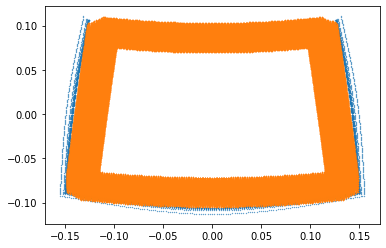

In [44]:
i_layer = 0

z = layer_hull_z

plt.scatter(np.real(z), np.imag(z), s=1e-1)



plt.scatter(np.real(model.theta_z), np.imag(model.theta_z), s=1e-1)

In [11]:
t1 - t0, t2 - t1

(0.034898996353149414, 0.05598616600036621)

In [486]:
i_layer = 0

layer_array_hull = layer_array_hulls[i_layer]
layer_hull_verts = layer_array_hull.points[layer_array_hull.vertices]

In [494]:
z = (layer_hull_verts[:,0] + 1j*layer_hull_verts[:,1]) * np.exp(1j*np.pi/2)

In [496]:
tools.get_MARA(layer_hull_verts[:,0] + 1j*layer_hull_verts[:,1])

0

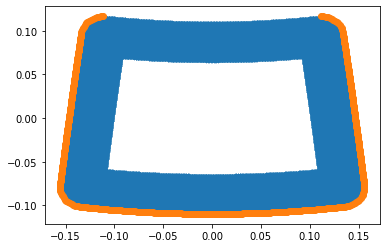

In [479]:
plt.scatter(edge_x, edge_y, s=1e-1)
plt.scatter(*array_hull.points[array_hull.vertices].T)

In [440]:
array_padding = (radius_sample_prop + beam_tol) * max_layer_beam_radii

array_padding.shape

(10,)

In [449]:
layer_hull_pts

[array([[-2.31287777e-02,  8.72664626e-03],
        [-2.31287777e-02, -8.72664626e-03],
        [-2.25187648e-02, -1.17933882e-02],
        [-2.07815950e-02, -1.43932465e-02],
        [-1.81817367e-02, -1.61304163e-02],
        [-3.06674197e-03, -2.48570626e-02],
        [-5.63805858e-18, -2.54670755e-02],
        [ 3.06674197e-03, -2.48570626e-02],
        [ 1.81817367e-02, -1.61304163e-02],
        [ 2.07815950e-02, -1.43932465e-02],
        [ 2.25187648e-02, -1.17933882e-02],
        [ 2.31287777e-02, -8.72664626e-03],
        [ 2.31287777e-02,  3.35640241e-03],
        [ 2.25474317e-02,  8.39100602e-03],
        [ 2.19374188e-02,  1.14577480e-02],
        [ 2.02002490e-02,  1.40576063e-02],
        [ 1.76003907e-02,  1.57947761e-02],
        [ 3.06674197e-03,  2.41857821e-02],
        [ 4.66887931e-18,  2.47957950e-02],
        [-3.06674197e-03,  2.41857821e-02],
        [-1.81817367e-02,  1.61304163e-02],
        [-2.07815950e-02,  1.43932465e-02],
        [-2.25187648e-02,  1.179

In [445]:
# (layer, frequency, detector, time)



# (layer, detector, time)

%time x = (model.x[None,:,:] - array.offset_x[None,:,None]) * ((array.offset_x[None,:,None] + array_padding[:,None,None]) / array.offset_x[None,:,None])

CPU times: user 138 ms, sys: 98.8 ms, total: 237 ms
Wall time: 239 ms


In [448]:
#x

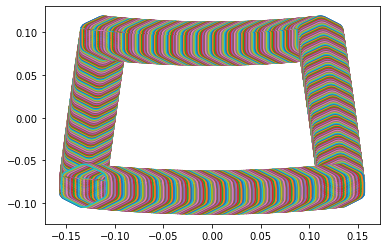

In [427]:
#plt.plot(pts[:,0][:,None] + plan.c_x[None,:], pts[:,1][:,None] + plan.c_y[None,:])
#plt.show()

In [421]:
pts[:,None,:] + np.c_[plan.c_x, plan.c_y][None,:,:]

array([[[-0.15654646, -0.07028201],
        [-0.15641533, -0.06912731],
        [-0.15628402, -0.06797262],
        ...,
        [-0.15123113, -0.0709277 ],
        [-0.1530032 , -0.07071537],
        [-0.15477498, -0.07050013]],

       [[-0.15654646, -0.0877353 ],
        [-0.15641533, -0.08658061],
        [-0.15628402, -0.08542591],
        ...,
        [-0.15123113, -0.08838099],
        [-0.1530032 , -0.08816866],
        [-0.15477498, -0.08795343]],

       [[-0.15593645, -0.09080204],
        [-0.15580532, -0.08964735],
        [-0.15567401, -0.08849265],
        ...,
        [-0.15062111, -0.09144774],
        [-0.15239319, -0.0912354 ],
        [-0.15416497, -0.09102017]],

       ...,

       [[-0.15159942, -0.06287824],
        [-0.15146829, -0.06172354],
        [-0.15133698, -0.06056885],
        ...,
        [-0.14628409, -0.06352393],
        [-0.14805616, -0.0633116 ],
        [-0.14982794, -0.06309636]],

       [[-0.15419928, -0.06461541],
        [-0.15406815, -0.06

In [417]:
pts.shape

(23, 2)

In [409]:
#scan_hull_pts = [np.concatenate([h_x[:,None] + plan.c_x[None,:], h_y[:,None] + plan.c_y[None,:]][:,:,None],axis=2) for h_x, h_y in zip(layer_hull_x, layer_hull_y)]

In [392]:
scan_hull_pts[0].shape

(58, 2400, 1)

In [378]:
#plt.plot(layer_hull_x[i], layer_hull_y[i])

In [364]:
layer_hull_points[0][:,None,:].shape

(29, 1, 2)

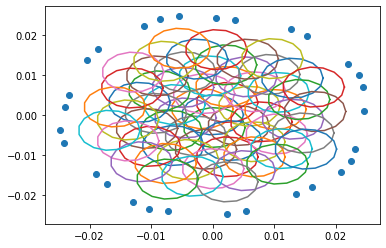

In [358]:
i = 0

h = layer_hulls[i]
r = max_layer_beam_radii[i]

plt.scatter(*h.points[h.vertices].T)
plt.plot(array.offset_x[None,:] + r * np.cos(np.linspace(0,2*np.pi,16))[:,None], 
            array.offset_y[None,:] + r * np.sin(np.linspace(0,2*np.pi,16))[:,None])
plt.show()

In [308]:
layer_hulls[0].vertices

array([1903, 1904, 1905, 1906, 1907, 1747, 1748, 2004, 2005, 2006, 2007,
       2008, 1848, 1849, 1850, 1851, 1691, 1947, 1948, 1949, 1950, 1951,
       1791, 1760, 2016, 2017, 2018, 2019, 2020, 1860, 1861, 1862, 1863,
       1703, 1704, 1960, 1961, 1962, 1963, 1803, 1804, 1805, 1806, 1646,
       1647], dtype=int32)

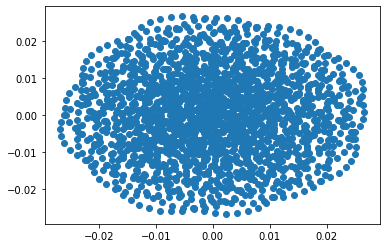

In [282]:


z = max_layer_beam_waist[:,None,None] * unit_z[None,:,None] + array.offset_z[None,None,:]
plt.scatter(np.real(z[0]), np.imag(z[0]))

In [255]:
model.array.offset_z[hull.vertices]

array([-0.00540714+0.01666758j, -0.01294281+0.01069399j,
       -0.01589918+0.00198148j, -0.01679421-0.00386431j,
       -0.01157223-0.01174284j, -0.0073311 -0.01607277j,
        0.00234056-0.01677597j,  0.01048641-0.01231986j,
        0.01512037-0.00856659j,  0.01661693+0.00084963j,
        0.01639335+0.0069549j ,  0.00969005+0.01407295j,
        0.00059524+0.01632247j])

In [248]:
model.angular_waists.max(axis=1)

array([0.01001723, 0.00503437, 0.00338467, 0.00256805, 0.00208444,
       0.0017671 , 0.00154457, 0.00138108, 0.00125676, 0.00115969])

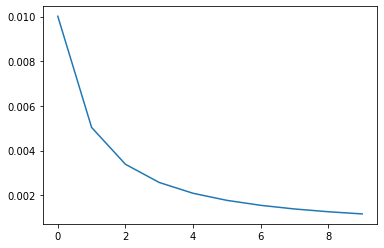

In [245]:
plt.plot(model.angular_waists.max(axis=1))

In [242]:
model.array.offset_z

array([ 0.00000000e+00+0.j        , -1.65432667e-03+0.0015155j ,
        2.77389941e-04-0.00316072j,  2.36436238e-03+0.00308389j,
       -4.41851516e-03-0.00078157j,  4.23289974e-03-0.00269262j,
       -1.42667149e-03+0.00530715j, -2.73589116e-03-0.00526779j,
        5.96067758e-03+0.00217683j, -6.22145667e-03+0.00256813j,
        3.00707703e-03-0.00642595j,  2.22697896e-03+0.00709996j,
       -6.72433326e-03-0.00389689j,  7.90057245e-03-0.00173692j,
       -4.82798684e-03+0.00686731j, -1.11666101e-03-0.0086172j ,
        6.86212433e-03+0.00578341j, -9.24250953e-03+0.00038221j,
        6.74705814e-03-0.00671422j, -4.51725728e-04+0.00976899j,
       -6.42854057e-03-0.00770354j,  1.01894370e-02+0.00137097j,
       -8.63805614e-03+0.00601013j,  2.36155491e-03-0.01049735j,
        5.46457642e-03+0.00953641j, -1.06870870e-02-0.00340947j,
        1.03850617e-02-0.00479816j, -4.50064102e-03+0.01075405j,
       -4.01802771e-03-0.01117114j,  1.06947759e-02+0.00562087j,
       -1.18825623e-02+0.

In [236]:
model.angular_waists.shape

(10, 270)

In [228]:
model.angular_waists

array([[0.01001723, 0.01001622, 0.01001529, ..., 0.01000067, 0.01000066,
        0.01000066],
       [0.00503437, 0.00503235, 0.00503051, ..., 0.00500135, 0.00500133,
        0.00500131],
       [0.00338467, 0.00338167, 0.00337893, ..., 0.00333535, 0.00333533,
        0.0033353 ],
       ...,
       [0.00138108, 0.00137371, 0.00136695, ..., 0.00125537, 0.00125531,
        0.00125524],
       [0.00125676, 0.00124866, 0.00124121, ..., 0.00111715, 0.00111708,
        0.00111701],
       [0.00115969, 0.00115091, 0.00114282, ..., 0.00100671, 0.00100663,
        0.00100655]])

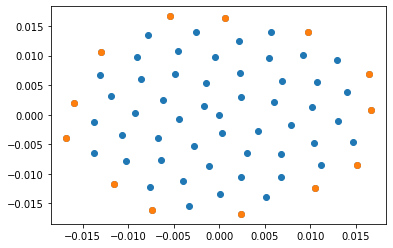

In [220]:

plt.scatter(*array.offsets.T)
plt.scatter(*hull.points[hull.vertices].T)

In [218]:
hull = sp.spatial.qhull.ConvexHull(array.offsets)
dir(hull)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_points',
 '_points',
 '_qhull',
 '_update',
 '_vertices',
 'add_points',
 'area',
 'close',
 'coplanar',
 'equations',
 'good',
 'max_bound',
 'min_bound',
 'ndim',
 'neighbors',
 'npoints',
 'nsimplex',
 'points',
 'simplices',
 'vertices',
 'volume']

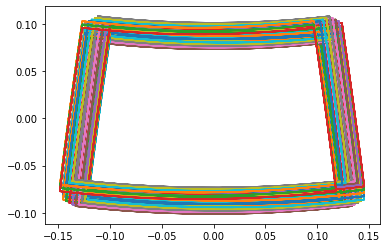

In [199]:
plt.plot(model.x.T, model.y.T)
plt.show()

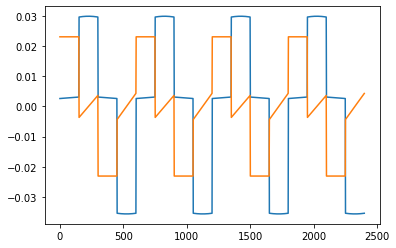

In [183]:
plt.plot(plan.c_x_v)
plt.plot(plan.c_y_v)

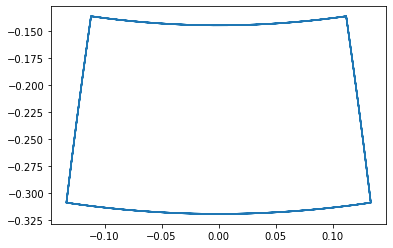

In [173]:
plt.plot(x, y)
#plt.plot(y)

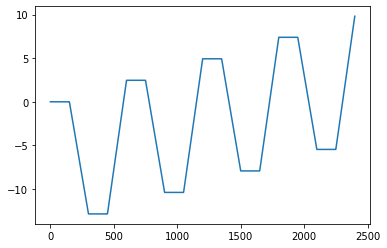

In [164]:
plt.plot(np.cumsum(plan.x_v*plan.dt))

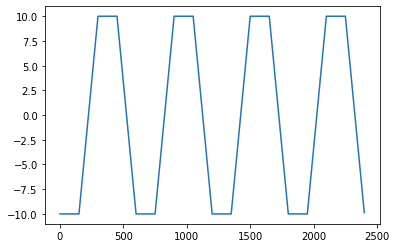

In [146]:
plt.plot(plan.azim)

In [133]:
array.x

array([-4.68489716e-17, -1.73205081e-01, -1.73205081e-01, -8.35883756e-17,
        1.73205081e-01,  1.73205081e-01,  1.43833684e-17, -3.46410162e-01,
       -3.46410162e-01, -3.46410162e-01, -1.73205081e-01, -1.20327780e-16,
        1.73205081e-01,  3.46410162e-01,  3.46410162e-01,  3.46410162e-01,
        1.73205081e-01,  7.56157083e-17, -1.73205081e-01, -5.19615242e-01,
       -5.19615242e-01, -5.19615242e-01, -5.19615242e-01, -3.46410162e-01,
       -1.73205081e-01, -1.57067184e-16,  1.73205081e-01,  3.46410162e-01,
        5.19615242e-01,  5.19615242e-01,  5.19615242e-01,  5.19615242e-01,
        3.46410162e-01,  1.73205081e-01,  1.36848048e-16, -1.73205081e-01,
       -3.46410162e-01, -6.92820323e-01, -6.92820323e-01, -6.92820323e-01,
       -6.92820323e-01, -6.92820323e-01, -5.19615242e-01, -3.46410162e-01,
       -1.73205081e-01, -1.93806587e-16,  1.73205081e-01,  3.46410162e-01,
        5.19615242e-01,  6.92820323e-01,  6.92820323e-01,  6.92820323e-01,
        6.92820323e-01,  

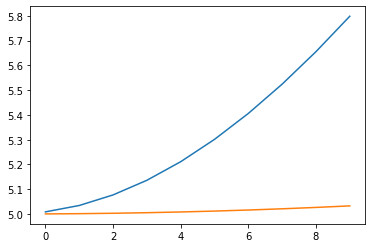

In [132]:
plt.plot(model.waists[:,0])
plt.plot(model.waists[:,-1])

In [125]:
array.bands

array([4.0e+10, 4.0e+10, 4.0e+10, 4.0e+10, 4.0e+10, 4.0e+10, 4.0e+10,
       4.0e+10, 4.0e+10, 4.0e+10, 4.0e+10, 4.0e+10, 4.0e+10, 4.0e+10,
       4.0e+10, 4.0e+10, 8.0e+10, 8.0e+10, 8.0e+10, 8.0e+10, 8.0e+10,
       8.0e+10, 8.0e+10, 8.0e+10, 8.0e+10, 8.0e+10, 8.0e+10, 8.0e+10,
       8.0e+10, 8.0e+10, 8.0e+10, 8.0e+10, 1.2e+11, 1.2e+11, 1.2e+11,
       1.2e+11, 1.2e+11, 1.2e+11, 1.2e+11, 1.2e+11, 1.2e+11, 1.2e+11,
       1.2e+11, 1.2e+11, 1.2e+11, 1.2e+11, 1.2e+11, 1.2e+11, 1.6e+11,
       1.6e+11, 1.6e+11, 1.6e+11, 1.6e+11, 1.6e+11, 1.6e+11, 1.6e+11,
       1.6e+11, 1.6e+11, 1.6e+11, 1.6e+11, 1.6e+11, 1.6e+11, 1.6e+11,
       1.6e+11])

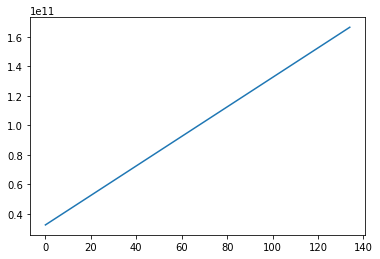

In [126]:
plt.plot(array.nu)

In [127]:
array.passbands

array([[7.86438349e-13, 3.04427398e-05, 1.24511210e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.86438349e-13, 3.04427398e-05, 1.24511210e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.86438349e-13, 3.04427398e-05, 1.24511210e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.90570005e-02, 1.24511210e-02, 3.04427398e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.90570005e-02, 1.24511210e-02, 3.04427398e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.90570005e-02, 1.24511210e-02, 3.04427398e-05]])

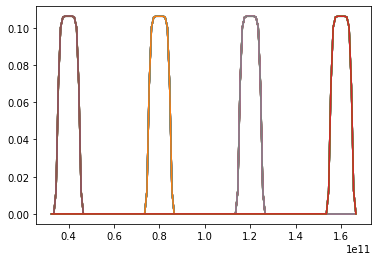

In [128]:
for i_det in range(array.n_det):

    plt.plot(array.nu, array.passbands[i_det])

In [77]:
array.passbands.shape

(64, 75)

In [ ]:
model = maria.lam(array, plan, site)

model.initialize()




In [54]:
offsets = np.random.standard_normal(size=(64,2))

In [55]:
datetime(2000,1,1).timestamp

<function datetime.timestamp>

In [72]:
def iterize(x):
    return np.array([x]).ravel()
    
iterize([5,10])

array([ 5, 10])

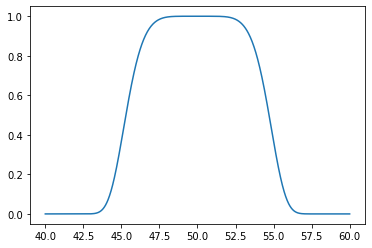

In [85]:
def get_passband(nu, nu_0, nu_w, order=4):
    return np.exp(-np.abs(2*(nu-nu_0)/nu_w)**order)

nu = np.linspace(40,60,1000)

plt.plot(nu, get_passband(nu, 50, 10, order=6))

In [74]:
np.repeat([5,10],5)

array([ 5,  5,  5,  5,  5, 10, 10, 10, 10, 10])

In [ ]:
self.beams.get_waist(self.atmosphere.depths[:,None],
                    self.beams.aperture,
                    self.array.nom_band_list[None,:])

In [59]:
model.depths

array([ 500., 1000., 1500., 2000.])

In [58]:
dir(model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'config',
 'depths',
 'initialize',
 'max_depth',
 'min_depth',
 'n_layers',
 'put',
 'site_mode']

In [7]:
plan = maria.plan()

plan.put({'el_throw' : 5,
          'scan_type' : 'box',
          'duration' : 600}, verbose=True)

auto
set el_throw to 5
set scan_type to box
set duration to 600


In [ ]:
model = maria.lam()

In [21]:
plan.config

{'duration': 600,
 'sample_rate': 20,
 'scan_period': 30,
 'scan_type': 'box',
 'az': 0,
 'el': 45,
 'az_throw': 10,
 'el_throw': 5}

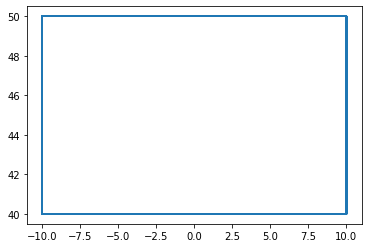

In [23]:
plt.plot(plan.azim, plan.elev)

auto
set n_det to 256
set fov to 2


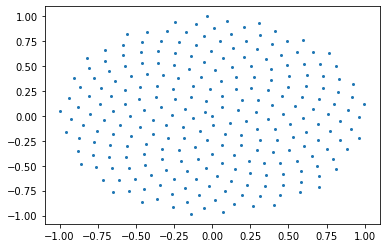

In [47]:
array = maria.array({'shape' : 'flower'})

#site = maria.site()


#plan = maria.plan()
array.put({'n_det' : 256, 'fov' : 2}, verbose=True)



plt.scatter(*array.offsets.T, s=4)

In [48]:

sp.signal


NameError: name 'sp' is not defined

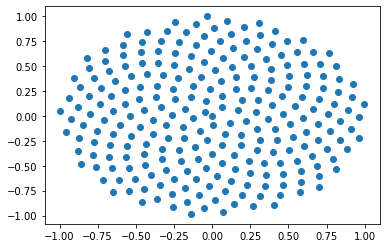

In [112]:
plt.scatter(*array.offsets.T)

In [ ]:

model = maria.lam()

model.initialize()
model.simulate()

In [ ]:
model.array

model.site

model.plans

In [ ]:
model.array()



In [6]:
model.array.offsets

AttributeError: 'Model' object has no attribute 'array'

In [20]:
array = telescope.Array()



site = telescope.Site()


#array.offsets

In [15]:
maria.model()

NameError: name 'maria' is not defined

In [25]:
from maria import model

model = maria.model(telescope='act')

model.put({'latitude' : 0,
           'longitude' : 0,
           'altitude' : 0})

model.initialize()

model.simulate()






TypeError: 'module' object is not callable

In [20]:
maria.telescope

NameError: name 'maria' is not defined